# Local Quickstart: Explainable AI (XAI) tools with Obz AI 

**Obz AI package** is designed to monitor your vision models behaviour. In particular, it logs *post hoc* explainability maps and applys outlier detection. However, first of all you need to define your model which you would like to monitor.

In [ ]:
%pip install obzai

Import necessary Python libraries.

In [10]:
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch import nn
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt

Let's define a Vision Transformer based on DINO ViT Backbone! To quickly look at XAI functionalities, we download and utilize a fine-tuned DINO ViT model on *Imagenette* dataset. In practice, you would have already trained or fine-tuned a deep learning model suitable for your data. 

In [5]:
def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    
    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1zV21_xkjk6YamJ6Yrj6d5u1FzxC-oY37"
output_dir = "tuned_models"
filename = "imagenette_dino_s8.pth"
download_weights(url, output_dir, filename)

Downloading...
From (original): https://drive.google.com/uc?id=1zV21_xkjk6YamJ6Yrj6d5u1FzxC-oY37
From (redirected): https://drive.google.com/uc?id=1zV21_xkjk6YamJ6Yrj6d5u1FzxC-oY37&confirm=t&uuid=4d478207-c7b9-4a08-8c3d-c89bc73da428
To: /Users/ncc/GitHub/alethia-xai/obzai/tutorials/tuned_models/imagenette_dino_s8.pth
100%|██████████| 87.4M/87.4M [00:02<00:00, 38.9MB/s]


## Configure the ViT classifer based on DINO backbone

We are adding a binary classification head (see how ```torch.nn.Linear```) onto a DINO backbone.

In [4]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 10)
    
    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

We load the pre-trained weights onto this model.

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/imagenette_dino_s8.pth"

MODEL = DINO()
MODEL.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE)))
MODEL = MODEL.to(DEVICE).eval()

Next, let's prepare the datasets. In this tutorial, we focus on XAI such that the model is applied on samples to classify and explanations are computed using attention maps. In general, you likely want to consider two separate sets of images at the minimum -- Reference and Inference data.

For this tutorial, we will use a subset of the ImageNet dataset called **Imagenette** as our example data source. We download them if needed:

In [15]:
# Transforms
TRANSFORMS = v2.Compose([v2.ToImage(), 
                         v2.ToDtype(torch.float32, scale=True), 
                         v2.CenterCrop(size=(160,160)),
                         v2.Resize(size=(224,224))])
NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Datasets
train_ds = Imagenette(root="./example_data", split='train', size='160px', transform=TRANSFORMS, download=False)
ref_set = torch.utils.data.Subset(train_ds, indices=[i for i in range(0, len(train_ds), 10)])
val_ds = Imagenette(root="./example_data", split='val', size='160px', transform=TRANSFORMS)

# DataLoaders
ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(val_ds, batch_size=6, shuffle=True)

# Labels mapping
CLASS_NAMES = ["tench", "English springer", "cassette player", 
               "chain saw", "church", "French horn", "garbage truck", 
               "gas pump", "golf ball", "parachute"]

LOGIT2NAME = {
    0: "tench",
    1: "English springer",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "French horn",
    6: "garbage truck",
    7: "gas pump",
    8: "golf ball",
    9: "parachute"
}

Visualize the first 5 samples from ref_loader.

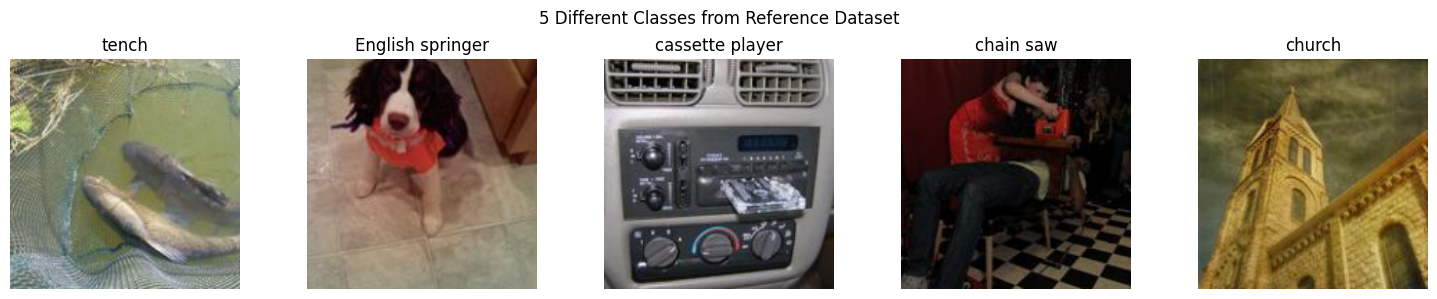

In [13]:
# Get a batch from ref_loader that has different classes
images_diff_classes = []
labels_diff_classes = []
seen_classes = set()

for batch_images, batch_labels in ref_loader:
    for img, label in zip(batch_images, batch_labels):
        if label.item() not in seen_classes:
            images_diff_classes.append(img)
            labels_diff_classes.append(label)
            seen_classes.add(label.item())
            if len(seen_classes) == 5:
                break
    if len(seen_classes) == 5:
        break

# Create a new figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('5 Different Classes from Reference Dataset')

# Display the 5 different class images
for idx in range(5):
    img = images_diff_classes[idx].movedim((0,1,2),(2,0,1)).numpy()
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title(f'{CLASS_NAMES[labels_diff_classes[idx]]}')

plt.tight_layout()
plt.show()

In [14]:
# Stack the images into a batch
batch_images = torch.stack(images_diff_classes)

# Normalize the images before feeding to the model
norm_batch = NORMALIZE(batch_images).to(DEVICE)

# Make predictions
with torch.no_grad():
    logits = MODEL(norm_batch)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predictions = torch.argmax(logits, dim=1)

# Print results
print("Predictions for the 5 images:")
print("-" * 50)
for i in range(5):
    true_label = labels_diff_classes[i].item()
    pred_label = predictions[i].item()
    confidence = probabilities[i][pred_label].item()
    print(f"Image {i+1}:")
    print(f"True class: {CLASS_NAMES[true_label]}")
    print(f"Predicted class: {CLASS_NAMES[pred_label]}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 50)

Predictions for the 5 images:
--------------------------------------------------
Image 1:
True class: tench
Predicted class: tench
Confidence: 70.28%
--------------------------------------------------
Image 2:
True class: English springer
Predicted class: English springer
Confidence: 99.16%
--------------------------------------------------
Image 3:
True class: cassette player
Predicted class: cassette player
Confidence: 98.67%
--------------------------------------------------
Image 4:
True class: chain saw
Predicted class: chain saw
Confidence: 94.21%
--------------------------------------------------
Image 5:
True class: church
Predicted class: church
Confidence: 99.34%
--------------------------------------------------


## XAI Module Setup

**XAI Module** have components to both provide you with easy-to-use explainability tools and evaluation tools. Module consist of two major ingredients:
* **XAITool** - Particular implementations of explainability methods.
* **XAIEval** - Evaluation methods for achieved explainability maps.  

Let's do some imports!


In [16]:
from obzai.xai.eval_tool import Fidelity, Compactness
import matplotlib.pyplot as plt
from obzai.xai.xai_tool import CDAM, SaliencyMap, AttentionMap
from obzai.xai.xai_regions import XAIRegions

Let's instantiate few objects:

#### XAITool
* ```cdam_tool``` - It is an excellent explainability method, highly discriminative with regards to the target class.
* ```smooth_grad_tool``` - Classical and simple XAI method.
* ```attention_tool``` - Classical way to inspect ViT like models.

#### XAIEval
* ```fidelity_tool``` - It is an explainability maps evaluation tool. It assess xai map quality by measuring behaviour of output logits in case of input perturbation.
* ```compactness_tool``` - It is just another xai maps evaluation tool. 

In [26]:
# XAITool:
cdam_tool = CDAM(model=MODEL, 
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_probabilities",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="softmax")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

smooth_grad_tool = SaliencyMap(model=MODEL, mode="vanilla")

attention_tool = AttentionMap(model=MODEL)

# XAIRegions:
# Wraps existing XAI tools to merges attribution scores with pixel regions to achieve more visually appealing XAI maps.
xai_regions_tool = XAIRegions()

# XAIEval:
fidelity_tool = Fidelity(model=MODEL, device=DEVICE) # Needs to specify the device
compactness_tool = Compactness()


Using device: cpu


**That is all!** Your explainability and evaluation tools are ready to use! Let's try it.

In [28]:
from obzai.xai import xai_utils

# Get fresh batch of images
image_batch, _ = next(iter(inf_loader))
image_batch = image_batch[:3]

# Make prediction
with torch.no_grad():
    norm_image_batch = NORMALIZE(image_batch).to(DEVICE)
    logits = MODEL(norm_image_batch)
    max_logits_idxs = torch.argmax(logits, dim=1).cpu().tolist()
    probabilities = torch.nn.functional.softmax(logits, dim=1)

# Achieving XAI maps. You can specify for which logit you want to achieve explanations!
cdam_maps = cdam_tool.explain(norm_image_batch, target_idx=max_logits_idxs)
smooth_grad_maps = smooth_grad_tool.explain(norm_image_batch, target_idx=max_logits_idxs)
attention_maps = attention_tool.explain(norm_image_batch)

# Region-based XAI maps
cdam_regions_maps = xai_regions_tool.regionize(raw_images=image_batch, attribution_maps=cdam_maps)
attention_regions_maps = xai_regions_tool.regionize(raw_images=image_batch, attribution_maps=attention_maps)

There are several Explainable AI (XAI) methods available, each with their own advantages and limitations. Obz AI offers a set of evaluation tools to help assess the quality of XAI methods.

`fidelity_tool` measures how accurately a given XAI method reflects the model’s true decision process. It does this by systematically perturbing input features based on their importance scores and observing the resulting change in the model performance.

`compactness_tool` evaluates how sparse and concentrated the importance scores are. A more compact set of importance scores is often easier for humans to interpret, as it highlights the most relevant features in a concise manner. 

By using these tools, you can better understand and compare the effectiveness and interpretability of different XAI approaches.

In [29]:
# Evaluating the XAI method
scores_fid = fidelity_tool.score(image_batch, cdam_maps, target_logits=max_logits_idxs)
scores_comp = compactness_tool.score(cdam_maps)
print("Fidelity: ", scores_fid[:3])
print("Compactness: ", scores_comp[:3])

Fidelity:  [3.2116251982748514, 0.7017510235309603, -0.8454652070999145]
Compactness:  [0.4923469387755102, 0.4247448979591837, 0.5]


We can now visualize resulting XAI Maps. We run the normalization function for each of XAI maps before calling the plotting functions.

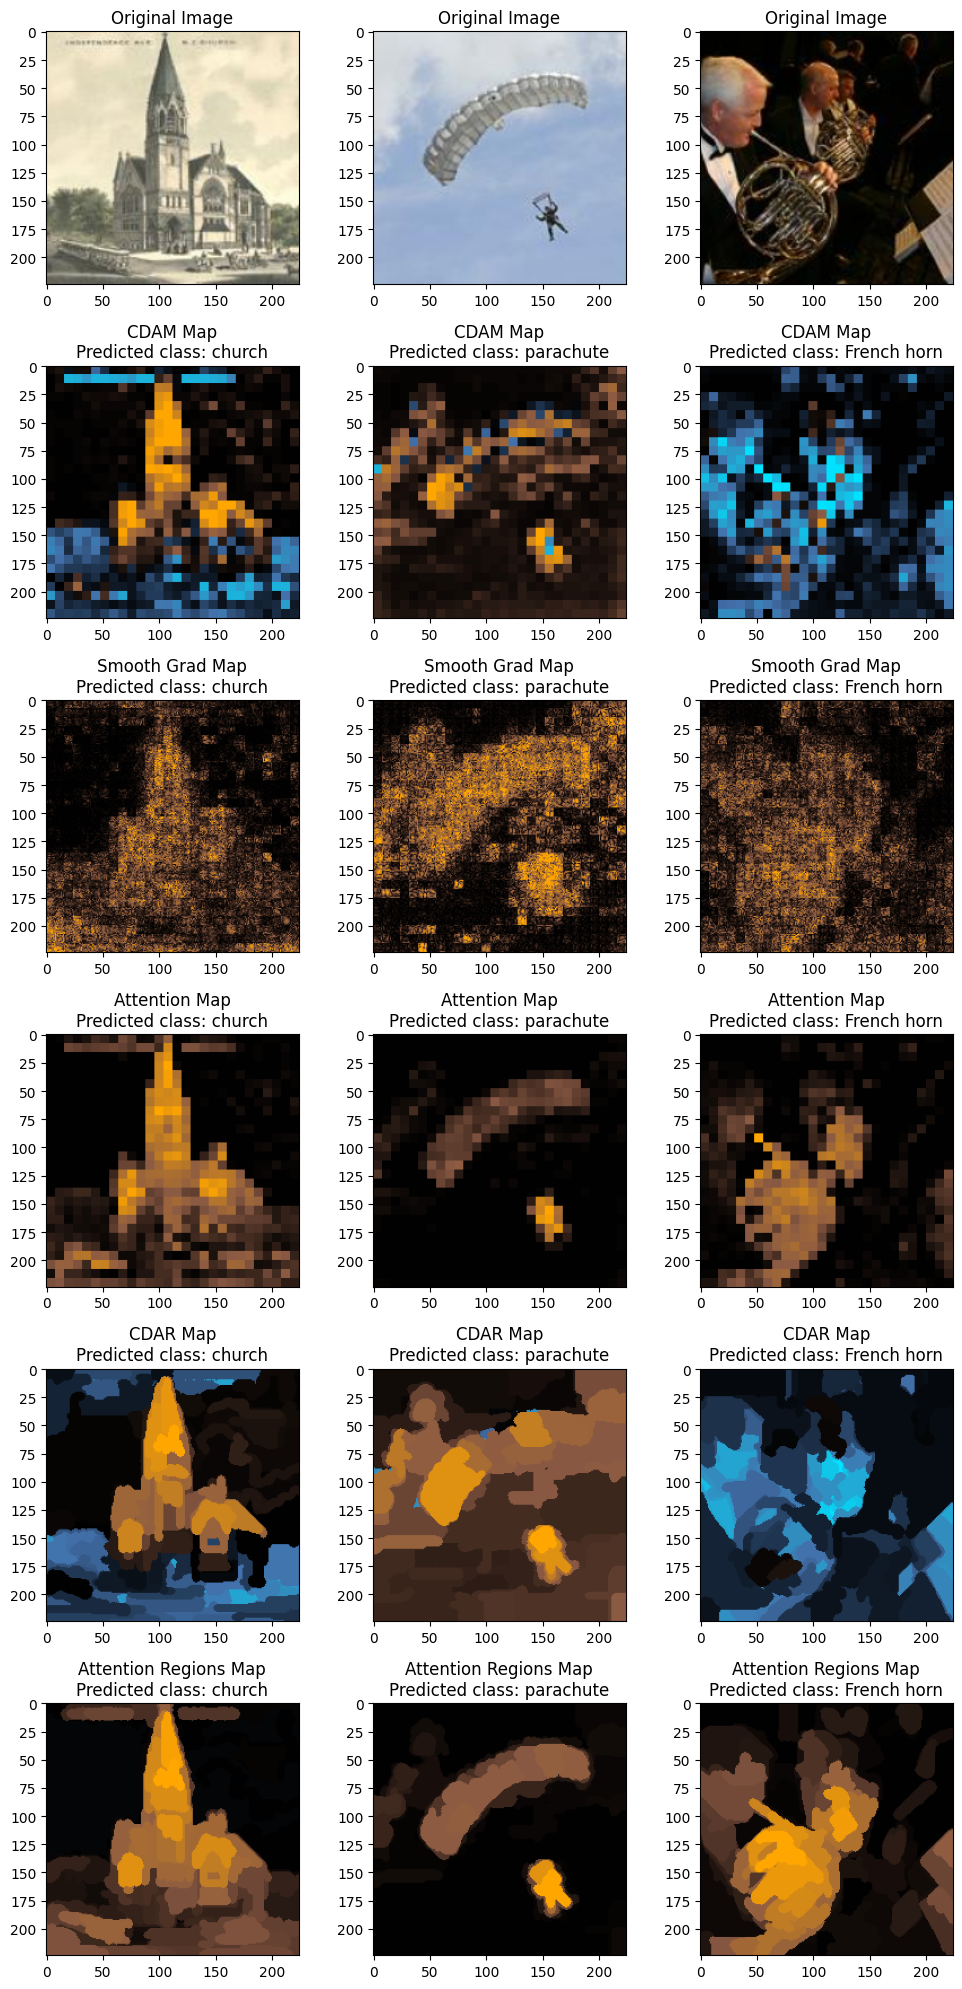

In [30]:
# Normalizing maps for visualization
norm_cdam_maps = xai_utils.normalize_xai_maps(cdam_maps)
norm_smooth_grad_maps = xai_utils.normalize_xai_maps(smooth_grad_maps)
norm_attention_maps = xai_utils.normalize_xai_maps(attention_maps)
norm_cdam_regions_map = xai_utils.normalize_xai_maps([map_ for map_ in cdam_regions_maps])
norm_attention_regions_map = xai_utils.normalize_xai_maps([map_ for map_ in attention_regions_maps])

# Plotting the normalized XAI maps
fig, axs = plt.subplots(6, 3, figsize=(10, 20))
for example_idx in range(3):
    # Original image
    axs[0][example_idx].imshow(image_batch[example_idx].movedim((0,1,2),(2,0,1)).numpy())
    axs[0][example_idx].set_title("Original Image")
    # CDAM map
    axs[1][example_idx].imshow(norm_cdam_maps[example_idx])
    axs[1][example_idx].set_title(f"CDAM Map\nPredicted class: {CLASS_NAMES[max_logits_idxs[example_idx]]}")
    # SmoothGrad map
    axs[2][example_idx].imshow(norm_smooth_grad_maps[example_idx])
    axs[2][example_idx].set_title(f"Smooth Grad Map\nPredicted class: {CLASS_NAMES[max_logits_idxs[example_idx]]}")
    # Attention map
    axs[3][example_idx].imshow(norm_attention_maps[example_idx])
    axs[3][example_idx].set_title(f"Attention Map\nPredicted class: {CLASS_NAMES[max_logits_idxs[example_idx]]}")
    # CDAR
    axs[4][example_idx].imshow(norm_cdam_regions_map[example_idx])
    axs[4][example_idx].set_title(f"CDAR Map\nPredicted class: {CLASS_NAMES[max_logits_idxs[example_idx]]}")
    # Attention Regions
    axs[5][example_idx].imshow(norm_attention_regions_map[example_idx])
    axs[5][example_idx].set_title(f"Attention Regions Map\nPredicted class: {CLASS_NAMES[max_logits_idxs[example_idx]]}")
fig.tight_layout()
plt.show()